In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_train = pd.read_csv('data/train.csv')

# Dropped named deemed irrelevant for prediction
df_train = df_train.drop(columns=['Name'])

# Observation

People within the same group (i.e., sharing the same GroupId) often share the same HomePlanet. This suggests that filling missing HomePlanet values based on group information could improve data quality.

In [3]:
df_train['Group'] = df_train['PassengerId'].str.split('_').str[0]

def same_value_percentage(series):
  counts = series.value_counts(dropna=True)
  max_count = counts.max()
  total_count = counts.sum()
  return max_count / total_count * 100

percentages_home_planet = df_train.groupby('Group')['HomePlanet'].apply(same_value_percentage, include_groups=False).reset_index()
print(f'Mean of same Home Planet based on Group: {percentages_home_planet["HomePlanet"].mean()}')

Mean of same Home Planet based on Group: 100.0


## Fill Home Planet based on Group

In [4]:
def fill_group_home_planet(group):
  choices_home_planet = ["Earth", "Europa", "Mars"]
  # check if any non-missing values exist in the group
  if group['HomePlanet'].notna().any():
    # fill missing values with the most common HomePlanet in the group
    group['HomePlanet'] = group['HomePlanet'].fillna(group['HomePlanet'].dropna().iloc[0])
  else:
    group['HomePlanet'] = group['HomePlanet'].fillna(np.random.choice(choices_home_planet))
  return group

df_train = df_train.groupby('Group').apply(fill_group_home_planet, include_groups = False).reset_index(drop=True)
print(df_train.isna().sum())

PassengerId       0
HomePlanet        0
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64


In [5]:
spending_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
total_spending_col = df_train['TotalSpending'] = df_train[spending_cols].sum(axis=1, skipna=True)

# Observation

The passengers who were cryosleeping did not spend any money on amenities like RoomService, FoodCourt, ShoppingMall, Spa, or VRDeck. This indicates that if a passenger has non-zero spending in these categories, they likely were not in cryosleep and vice versa.

In [6]:
result = df_train.groupby('CryoSleep')['TotalSpending'].agg(['count', 'mean'])
print(result)

           count         mean
CryoSleep                    
False       5439  2248.299687
True        3037     0.000000


# Fill NaN CryoSleep values based on spending

In [7]:
mask_cryosleep_nan = df_train['CryoSleep'].isna()

df_train.loc[mask_cryosleep_nan, 'CryoSleep'] = total_spending_col[mask_cryosleep_nan].gt(0).map({True: False, False: True})

print(df_train.isna().sum())

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin            199
Destination      182
Age              179
VIP              203
RoomService      181
FoodCourt        183
ShoppingMall     208
Spa              183
VRDeck           188
Transported        0
TotalSpending      0
dtype: int64


# Observation

- Passengers with an age below 13 don't spend any money on amenities like RoomService, FoodCourt, ShoppingMall, Spa, or VRDeck. This suggests that passengers falling below 13 won't have any spending in these categories.

- Passengers with an age below 13 don't have VIP status. This indicates that passengers under 13 are not considered VIPs.

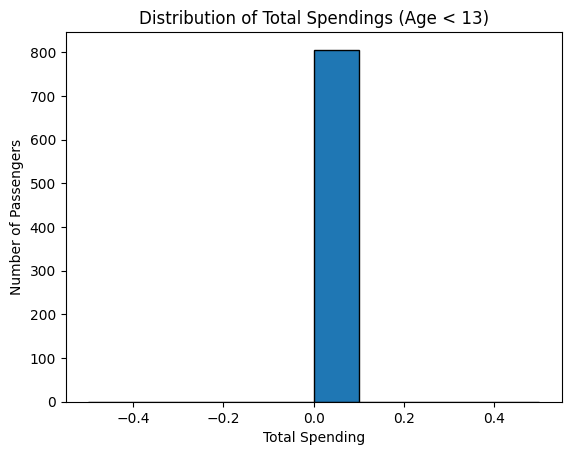

In [8]:
kids = df_train[df_train["Age"] < 13]

total_spending_kids = kids[spending_cols].sum(axis=1, skipna=True)

plt.hist(total_spending_kids, edgecolor='black')

plt.title("Distribution of Total Spendings (Age < 13)")
plt.xlabel("Total Spending")
plt.ylabel("Number of Passengers")
plt.show()

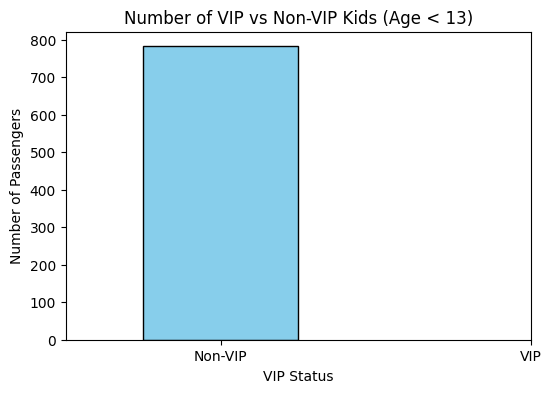

In [9]:
# Count VIP and non-VIP kids
vip_counts = kids["VIP"].value_counts()

# Plot bar chart
plt.figure(figsize=(6,4))
vip_counts.plot(kind='bar', color=['skyblue', 'orange'], edgecolor='black')

plt.title("Number of VIP vs Non-VIP Kids (Age < 13)")
plt.xlabel("VIP Status")
plt.ylabel("Number of Passengers")
plt.xticks(ticks=[0,1], labels=['Non-VIP', 'VIP'], rotation=0)
plt.show()

# Fill NaN spending cols values based on passenger age < 13 & crysleep == True

In [10]:
kids_and_cryosleeping_mask = (
    (df_train["Age"] < 13) |
    (df_train["CryoSleep"] == True) |
    # This condition ensures we only target rows where all spending columns are NaN
    (df_train[spending_cols].isna().all(axis=1))
)
df_train.loc[kids_and_cryosleeping_mask, spending_cols] = 0
print(df_train.isna().sum())

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin            199
Destination      182
Age              179
VIP              203
RoomService      107
FoodCourt        106
ShoppingMall     101
Spa              113
VRDeck           105
Transported        0
TotalSpending      0
dtype: int64


In [12]:
kids_non_vip_mask = df_train["Age"] < 13
df_train.loc[kids_non_vip_mask, "VIP"] = False
print(df_train.isna().sum())

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin            199
Destination      182
Age              179
VIP              179
RoomService      107
FoodCourt        106
ShoppingMall     101
Spa              113
VRDeck           105
Transported        0
TotalSpending      0
dtype: int64


In [19]:
print(df_train["Cabin"].nunique())

6560
